### Experiment 1: Solving the spatial alternation task with intact and disrupted spatial memory. 

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import numpy as np 
from pathlib import Path

import pandas as pd 

import hippo
from hippo.agents import HierarchicalAgent, AgentModes, load_hippo_agent, load_prefrontal_agent
from hippo.environments.action_perception import action_perception_loop
from hippo.environments.w_maze import get_wmaze, WmazeTasks


import matplotlib.pyplot as plt
from hippo.visualization import format_ax
from scipy.stats import ttest_ind, wilcoxon

In [13]:
gamma = 0.5

store_path = Path(hippo.__file__).parent.parent / f"data/results/experiment-1-gamma-{gamma}"
store_path.mkdir(exist_ok=True, parents=True)


In [ ]:
def to_dataframe(logs, control_mode, agent_name, trial):
    d_new = {
        "trial": [trial for _ in range(len(logs["action"]))],
        "agent_name": [agent_name for _ in range(len(logs["action"]))],
        "control_mode": [control_mode for _ in range(len(logs["action"]))],
        "time": np.arange(len(logs["action"])),
        "action": logs["action"],
        "reward": 1.0 * logs["reward"],
        "pos_x": [pose[0] for pose in logs["pose"]],
        "pos_y": [pose[1] for pose in logs["pose"]],
        "pos_dir": [pose[2] for pose in logs["pose"]],
        "rules": logs["rules"],
        "inbound": logs["inbound"],
    }
    return pd.DataFrame.from_dict(d_new)

To simulate the disruption at the task level, we change the prior belief (after transition) to a uniform distribution. This way, when the agent receives an observation, it only receives information from the emission model.

In [ ]:
def disrupt_qs0(agent, env_info):
    # step variable and state variable in both models coincidentillay correspond to
    # qs[0], so we dont need separate code for both
    agent.model_pf.agent.qs[0] = np.ones_like(agent.model_pf.agent.qs[0])
    agent.model_pf.agent.qs[0] /= agent.model_pf.agent.qs[0].sum()

In [ ]:
import random 

def run_experiment(agent_mode, store_path, n_trials=20, n_steps=300):
    """
    Runs the action control loop for an agent for multiple trials. 
    A control and disruption scenario is ran and the metrics are stored
    unless the agent is random (does not use state to select action) 
    """
    model_hippo = load_hippo_agent()
    model_pf = load_prefrontal_agent(agent_mode=agent_mode)

    agent = HierarchicalAgent(
        model_pf=model_pf,
        model_hippo=model_hippo,
        fe_threshold=-14.8,
        name=agent_mode.name,
    )
    agent.model_pf.agent.gamma = gamma

    controls = {AgentModes.RANDOM: [True]}

    run_logs_df = pd.DataFrame()
    for trial in range(n_trials):

        np.random.seed(trial)
        random.seed(trial)

        for control in controls.get(agent_mode, [True, False]): 
            callbacks = []
            if control:
                control_key = "control"
            else: 
                control_key = "disrupt"
                callbacks.append(disrupt_qs0)

            obs_light = agent_mode==AgentModes.CSCG_LIGHT_RULE0

            run_logs = action_perception_loop(
                get_wmaze(task_mode=WmazeTasks.TASK0),
                agent,
                n_steps,
                record_frames=True,
                record_agent_info=True,
                observable_reward=True,
                callbacks=callbacks,
                observable_light=obs_light
            )

            df = to_dataframe(run_logs, control_key, agent.name, trial)
            run_logs_df = pd.concat([run_logs_df, df])

    name = f"{agent_mode}_disrupt_swr.csv"
    run_logs_df.to_csv(store_path / name)

In [ ]:
run_experiment(AgentModes.RANDOM, store_path, n_trials=20, n_steps=300)

In [ ]:
run_experiment(AgentModes.CSCG_LOC_RULE0, store_path, n_trials=20, n_steps=300)

In [ ]:
run_experiment(AgentModes.CSCG_LOC, store_path, n_trials=20, n_steps=300)

In [ ]:
run_experiment(AgentModes.CSCG_LIGHT_RULE0, store_path, n_trials=20, n_steps=300)

#### Make the figures


In [14]:
def extract_reward_at_corridors(df):
    # only consider the corridor ends
    corridors = df[df["pos_y"] == 1]
    corridors = corridors[corridors["pos_dir"] == 3]
    #corridors = corridors[corridors['time'] > 50]

    grouped = corridors.groupby(["control_mode", "trial", "inbound"]).mean(["reward"]).reset_index()

    inbound = grouped[grouped["inbound"] == True]
    outbound = grouped[grouped["inbound"] == False]

    in_control = inbound[inbound['control_mode'] == "control"]["reward"].tolist()
    in_disrupt = inbound[inbound['control_mode'] == "disrupt"]["reward"].tolist()
    out_control = outbound[outbound['control_mode'] == "control"]["reward"].tolist()
    out_disrupt = outbound[outbound['control_mode'] == "disrupt"]["reward"].tolist()

    return (in_control, out_control), (in_disrupt, out_disrupt)

In [15]:
def plot_agent_success_rates(mode, agent_name="HAI", stats=True):
    (store_path / "figures").mkdir(exist_ok=True, parents=True)
    results = dict({})
    for agent_mode in [mode, AgentModes.RANDOM]:
        try: 
            data = pd.read_csv(store_path / f"{agent_mode}_disrupt_swr.csv")
            (inbound_c, outbound_c), (inbound_d, outbound_d) = extract_reward_at_corridors(data)

            results[agent_mode] = {
                "control": {
                    "inbound": inbound_c, 
                    "outbound": outbound_c
                }, 
                "disrupt": {
                    "inbound": inbound_d, 
                    "outbound": outbound_d
                }
            }
        except Exception as e: 
            print(e)

    labels = []
    inbounds, outbounds = [], []
    for k, v in results.items():
        if k == AgentModes.RANDOM:
            labels.append(k)
            inbounds.append(v["control"]["inbound"])
            outbounds.append(v["control"]["outbound"])
        else:
            labels.append(k + "\ncontrol")
            inbounds.append(v["control"]["inbound"])
            outbounds.append(v["control"]["outbound"])

            labels.append(k + "\ndisrupt")
            inbounds.append(v["disrupt"]["inbound"])
            outbounds.append(v["disrupt"]["outbound"])

        print(k)
        print("inbound", np.mean(inbounds[-2]), np.mean(inbounds[-1]))
        print("outbound", np.mean(outbounds[-2]), np.mean(outbounds[-1]))
        print()


    fig, ax = plt.subplots(1, 2, figsize=(6.5, 2))
    [format_ax(a) for a in ax.flatten()]

    medianprops = dict(linestyle='-', linewidth=1.0, color='black')
    ax[0].boxplot(inbounds, medianprops=medianprops)
    ax[0].set_title("Inbound trajectories")
    ax[1].boxplot(outbounds, medianprops=medianprops)
    ax[1].set_title("Outbound trajectories")

    for a in ax.flatten():
        a.set_xticklabels([agent_name, f"{agent_name}\ndisrupt", "Random\nAgent"])
        a.set_xlabel("")
        a.set_ylim([0.0, 1.075])
        format_ax(a)

    ax[0].set_ylabel("Success rate")
    # plt.tight_layout()
    tag = agent_name.replace('\n', '_').replace(' ', '_')
    plt.savefig(store_path / f"figures/boxplots_cscg_{tag}.svg", bbox_inches="tight")

    # ----
    if stats:
        pfc = []
        random = []
        for bound in ['inbound', 'outbound']:
            pfc += results[mode]['control'][bound]
            random += results[AgentModes.RANDOM]['control'][bound]

        print("Performance mPFC vs RANDOM t-test")
        print("T-test: ", ttest_ind(pfc, random))
        #print("Wilcoxon-test: ", wilcoxon(pfc, random))

CSCG_LOC_RULE0
inbound 0.974504662004662 0.9305173992673993
outbound 0.9036130536130536 0.3571530063074181

RANDOM
inbound 0.9305173992673993 0.36413814127049415
outbound 0.3571530063074181 0.34469267252355495

Performance mPFC vs RANDOM t-test
T-test:  TtestResult(statistic=20.07471578800707, pvalue=1.513951609439265e-32, df=78.0)


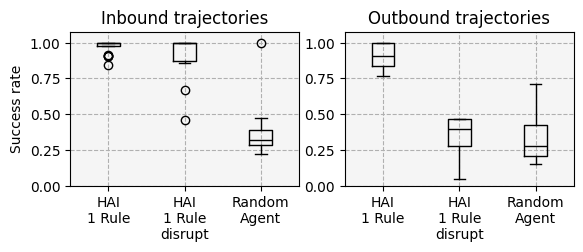

In [16]:
plot_agent_success_rates(AgentModes.CSCG_LOC_RULE0, "HAI\n1 Rule")

CSCG_LOC
inbound 0.9011188811188813 0.5481349206349206
outbound 0.8226323676323675 0.28962144473173884

RANDOM
inbound 0.5481349206349206 0.36413814127049415
outbound 0.28962144473173884 0.34469267252355495

Performance mPFC vs RANDOM t-test
T-test:  TtestResult(statistic=15.856060460433708, pvalue=4.0853023703461883e-26, df=78.0)


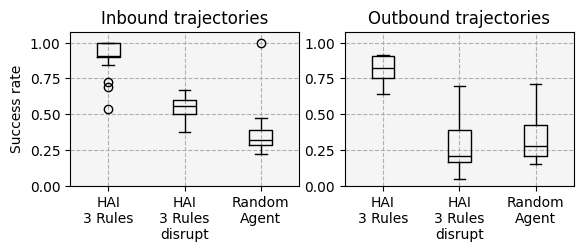

In [17]:
plot_agent_success_rates(AgentModes.CSCG_LOC, "HAI\n3 Rules")

CSCG_LIGHT_RULE0
inbound 0.9752622377622379 0.9631944444444445
outbound 0.9229312354312356 0.6016826923076922

RANDOM
inbound 0.9631944444444445 0.36413814127049415
outbound 0.6016826923076922 0.34469267252355495

Performance mPFC vs RANDOM t-test
T-test:  TtestResult(statistic=20.735942337910718, pvalue=1.792319351969389e-33, df=78.0)


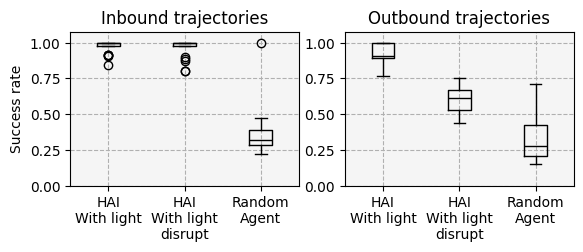

In [18]:
plot_agent_success_rates(AgentModes.CSCG_LIGHT_RULE0, "HAI\nWith light", stats=True)

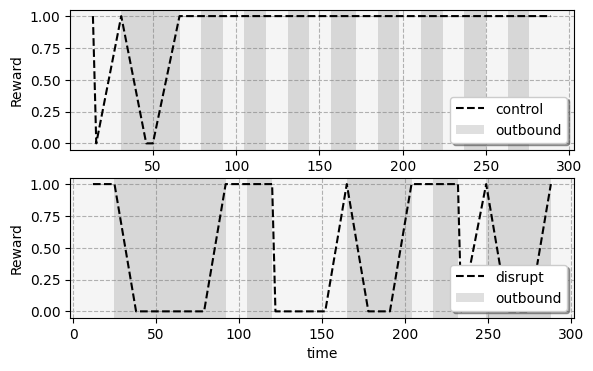

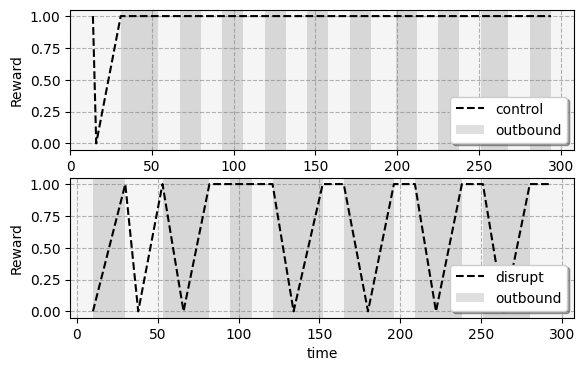

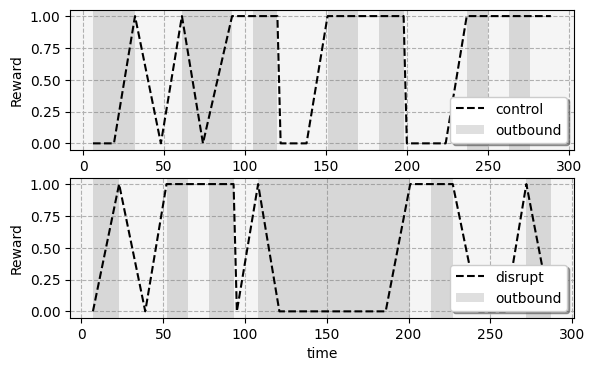

In [19]:
def plot_reward(agent_mode, trial_idx=1):
    data = pd.read_csv(store_path / f"{agent_mode}_disrupt_swr.csv")

    data = data[data["pos_y"] == 1]
    data = data[data["pos_dir"] == 3]

    seq = data[data["control_mode"] == "control"]
    seq_control = seq[seq["trial"] == trial_idx]

    seq = data[data["control_mode"] == "disrupt"]
    seq_disrupt = seq[seq["trial"] == trial_idx]

    fig, axes = plt.subplots(2, 1, figsize=(6.5, 4))
    ax = axes[0]

    for seq, label, ax in zip([seq_control, seq_disrupt],["control", "disrupt"],  axes.flatten()):
        seq.plot(
            x="time", y="reward", ax=ax, 
            color='black', label=label,
            linestyle='dashed'
        )
        ax.set_ylabel("Reward")
        format_ax(ax)

        iidcs = seq["time"]
        inbound = seq["inbound"]
        i0, ie = list(iidcs)[0], list(iidcs)[-1]
        for i1, i2, ib in zip(iidcs[:-1], iidcs[1:], inbound):
            if not ib:
                # c = 'tab:orange'
                c = 'gray'
                ax.axvspan(i1, i2, facecolor=c, alpha=0.25, label='outbound')

        handles, labels = ax.get_legend_handles_labels()
        unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
        ax.legend(*zip(*unique), loc="lower right", shadow=True, fancybox=True)

    plt.savefig(store_path / f"figures/{agent_mode}_time_reward.svg", bbox_inches='tight')
    plt.show()

plot_reward(AgentModes.CSCG_LOC_RULE0)
plot_reward(AgentModes.CSCG_LIGHT_RULE0)
plot_reward(AgentModes.CSCG_LOC)

___

## Types of errors 

In [20]:
from enum import StrEnum

class SequenceErrors(StrEnum): 
    ALTERNATION = "alternation"
    ROTATED_ALTERNATION = "rotated alternation"
    BACK_AND_FORTH = "back and forth"
    CIRCLING = "circling"
    OTHER = "other"

def seq_to_named_seq(seq): 
    names = {1: 'L', 4: 'C', 7: 'R'}
    return [names[i] for i in seq]


def analyze_sequence(seq): 
    sequence_to_label = {
        "CLCR": SequenceErrors.ALTERNATION,
        "CRCL": SequenceErrors.ALTERNATION,
        "LCRC": SequenceErrors.ALTERNATION,
        "RCLC": SequenceErrors.ALTERNATION,
        "LRLC": SequenceErrors.ROTATED_ALTERNATION,
        "LCLR": SequenceErrors.ROTATED_ALTERNATION,
        "RLCL": SequenceErrors.ROTATED_ALTERNATION,
        "CLRL": SequenceErrors.ROTATED_ALTERNATION,
        "RCRL": SequenceErrors.ROTATED_ALTERNATION,
        "RLRC": SequenceErrors.ROTATED_ALTERNATION,
        "CRLR": SequenceErrors.ROTATED_ALTERNATION,
        "LRCR": SequenceErrors.ROTATED_ALTERNATION,
        "CLCL": SequenceErrors.BACK_AND_FORTH,
        "LCLC": SequenceErrors.BACK_AND_FORTH,
        "CRCR": SequenceErrors.BACK_AND_FORTH,
        "RCRC": SequenceErrors.BACK_AND_FORTH,
        "LRLR": SequenceErrors.BACK_AND_FORTH,
        "RLRL": SequenceErrors.BACK_AND_FORTH,
        "CLRC": SequenceErrors.CIRCLING,
        "CRLC": SequenceErrors.CIRCLING,
        "LRCL": SequenceErrors.CIRCLING,
        "LCRL": SequenceErrors.CIRCLING,
        "RCLR": SequenceErrors.CIRCLING, 
        "RLCR": SequenceErrors.CIRCLING
    }

    error_lists = {
        SequenceErrors.ALTERNATION: np.zeros(len(seq)-4),
        SequenceErrors.ROTATED_ALTERNATION: np.zeros(len(seq)-4),
        SequenceErrors.BACK_AND_FORTH: np.zeros(len(seq)-4),
        SequenceErrors.CIRCLING: np.zeros(len(seq)-4),
        SequenceErrors.OTHER: np.zeros(len(seq)-4)
    }

    for i in range(len(seq)-4): 
        e_type = sequence_to_label.get("".join(seq[i:i+4]), SequenceErrors.OTHER)
        error_lists[e_type][i] = 1
    
    for e_type, values in error_lists.items(): 
        print(f"{e_type: <20}: {values.mean() * 100: .2f}%")

def get_error_stats(agent_name):
    data = pd.read_csv(store_path / f"{agent_name}_disrupt_swr.csv")
    for control_mode in ["control", "disrupt"]:

        corridors = data[data["agent_name"] == agent_name]
        corridors = corridors[corridors["time"] > 50]
        corridors = corridors[corridors["pos_y"] == 1]
        corridors = corridors[corridors["pos_dir"] == 3]
        corridors = corridors[corridors["control_mode"] == control_mode]

        visited_sequence = corridors["pos_x"].to_list()
        seq = seq_to_named_seq(visited_sequence)
        #print(" ".join(seq) )

        print(f"_{control_mode}_")
        analyze_sequence(seq)
        print()

        if agent_name == AgentModes.RANDOM:
            break 

In [21]:
get_error_stats(AgentModes.CSCG_LOC_RULE0)

_control_
alternation         :  86.33%
rotated alternation :  0.00%
back and forth      :  2.68%
circling            :  1.61%
other               :  9.38%

_disrupt_
alternation         :  49.07%
rotated alternation :  0.80%
back and forth      :  38.40%
circling            :  1.60%
other               :  10.13%



In [22]:
get_error_stats(AgentModes.CSCG_LOC)

_control_
alternation         :  76.00%
rotated alternation :  1.07%
back and forth      :  2.40%
circling            :  8.80%
other               :  11.73%

_disrupt_
alternation         :  16.80%
rotated alternation :  13.55%
back and forth      :  38.48%
circling            :  17.34%
other               :  13.82%



In [23]:
get_error_stats(AgentModes.RANDOM)

_control_
alternation         :  3.47%
rotated alternation :  8.24%
back and forth      :  8.68%
circling            :  5.86%
other               :  73.75%



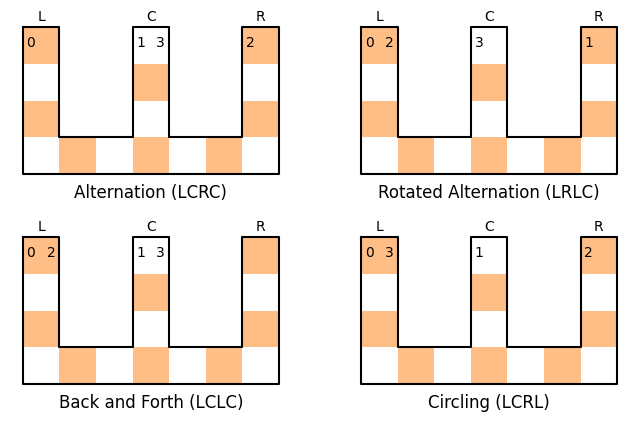

In [24]:
from hippo.visualization.maze import add_wmaze_plot

fig, ax = plt.subplots(2, 2, figsize=(8, 5))
ax = ax.flatten()

[a.axis('off') for a in ax.flatten()]
[a.set_aspect("equal") for a in ax.flatten()]
[add_wmaze_plot(a, "tab:orange") for a in ax.flatten()] 

def get_pos(loc):
    col_to_pos = {"L": (1, 1), "C": (4, 1), "R": (7, 1)}
    pos = col_to_pos[loc]
    return pos 


trajectory = "LCRC"
def add_trajectory(ax, trajectory):
    xs, ys = [], []
    for i, loc in enumerate(trajectory):
        pos = get_pos(loc)
        off_x = counts[loc] * 0.55 - 0.4
        counts[loc] += 1

        ax.text(pos[0] + off_x, pos[1], i)
        if i > 0: 
            xs.append(pos[0])
            ys.append(4)
        xs.append(pos[0])
        ys.append(1)
        if i < len(trajectory):
            # Down
            xs.append(pos[0])
            ys.append(4)

counts = {"L": 0, "C": 0, "R": 0}
add_trajectory(ax[0], "LCRC")
ax[0].set_title("Alternation (LCRC)", y=-0.15)

counts = {"L": 0, "C": 0, "R": 0}
add_trajectory(ax[1], "LRLC")
ax[1].set_title("Rotated Alternation (LRLC)", y=-0.15)

counts = {"L": 0, "C": 0, "R": 0}
add_trajectory(ax[2], "LCLC")
ax[2].set_title("Back and Forth (LCLC)", y=-0.15)

counts = {"L": 0, "C": 0, "R": 0}
add_trajectory(ax[3], "LCRL")
ax[3].set_title("Circling (LCRL)", y=-0.15)

plt.savefig(store_path / "figures/error_patterns.svg", bbox_inches="tight")